# Airbnb Berlin Price Prediction

The goal is to **predict** the price of a night’s accommodation in Berlin on the website Airbnb. 

## Import Modules

In [1]:
from ast import Tuple

from datetime import datetime
import seaborn as sns
import pandas as pd
import numpy as np

from IPython.display import display, clear_output
from scipy.stats import chi2_contingency
from haversine import haversine

from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.compose import ColumnTransformer, make_column_selector, make_column_transformer
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.experimental import enable_iterative_imputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.impute import IterativeImputer
from sklearn.decomposition import PCA
from sklearn.svm import SVR

import lazypredict
from lazypredict.Supervised import LazyRegressor

from xgboost import XGBRegressor

%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
sns.set()

# Style options for plots.
plt.rc('axes', labelsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)
plt.rc('figure', figsize=(9, 5))

# Style options for pandas
pd.set_option('display.max_columns', None)

# Settings

In [2]:
# Input data
path = 'data/airbnb_berlin.xls'
data = pd.read_csv(path)

# Parameters
test_size = 0.3
random_state = 42

In [3]:
data.head()

,Listing ID,Listing Name,Host ID,Host Name,Host Since,Host Response Time,Host Response Rate,Is Superhost,neighbourhood,Neighborhood Group,City,Postal Code,Country Code,Country,Latitude,Longitude,Is Exact Location,Property Type,Room Type,Accomodates,Bathrooms,Bedrooms,Beds,Square Feet,Guests Included,Min Nights,Reviews,First Review,Last Review,Overall Rating,Accuracy Rating,Cleanliness Rating,Checkin Rating,Communication Rating,Location Rating,Value Rating,Instant Bookable,Business Travel Ready,Price
0,19665213.00,*,156079597.00,Maximilian,2016-01-20,NaN,NaN,f,Prenzlauer Berg,Pankow,Berlin,10437.0,DE,Germany,52.55,13.42,t,Apartment,Private room,2,1.0,1.0,1.0,NaN,1,2,6,2017-07-07,2017-08-08,100.00,10.00,10.00,10.00,10.00,9.00,10.00,t,f,26.00
1,6436842.00,*,5302290.00,Dulie,2013-04-07,NaN,NaN,f,Pankow,Pankow,Berlin,13187.0,DE,Germany,52.57,13.42,t,Apartment,Entire home/apt,2,1.0,2.0,2.0,NaN,2,7,6,2015-05-26,2019-04-30,90.00,9.00,9.00,10.00,10.00,9.00,10.00,f,f,41.00
2,10559468.00,*,59151456.00,Geank,2016-02-07,NaN,NaN,f,Prenzlauer Berg,Pankow,Berlin,10439.0,DE,Germany,52.55,13.43,t,Apartment,Entire home/apt,3,1.0,1.0,2.0,NaN,1,1,2,2016-04-19,2016-07-04,100.00,10.00,10.00,10.00,10.00,10.00,10.00,f,f,50.00
3,27215482.00,*,193452785.00,Alix,2018-06-26,NaN,NaN,f,Friedrichshain,Friedrichshain-Kreuzberg,Berlin,10245,DE,Germany,52.51,13.45,t,Apartment,Private room,2,1.0,1.0,1.0,NaN,1,2,4,2018-07-31,2018-08-12,100.00,10.00,10.00,10.00,10.00,10.00,9.00,f,f,50.00
4,27287546.00,*,205870244.00,Lurina,2013-05-16,within a few hours,92%,t,Prenzlauer Berg,Pankow,Berlin,10405.0,DE,Germany,52.53,13.42,t,Apartment,Private room,3,1.0,1.0,2.0,NaN,1,6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,t,f,55.00


## Data Overview
Before even thinking of training models, it is necessary to get a better understanding of the available data.

The provided dataset consists of **15692** samples with **39** features each.

Before splitting the data, some basic cleaning is applied.

In [4]:
def clean_data(data: pd.DataFrame) -> None:
    """
    Cleans the data
    """    
    # Many values are actually *, which intuitively means they are missing. replace them by NaNs.
    data.replace('*', np.nan,inplace=True)
    # Drop rows with NaN in 'Price'
    data.dropna(subset=['Price'], inplace=True)
    # Convert date object to datetime
    data[['Host Since','First Review','Last Review']] = data[['Host Since','First Review','Last Review']].apply(pd.to_datetime)
    # Convert date to days count from reference date
    reference_date = datetime.strptime('2022-10-31', '%Y-%m-%d')
    data['Host Since'] = (reference_date - data['Host Since'] ).dt.days
    data['First Review'] = (reference_date - data['First Review'] ).dt.days
    data['Last Review'] = (reference_date - data['Last Review']).dt.days
    # Convert some columns to float
    cols = ['Accomodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Guests Included', 'Min Nights']
    data[cols] = data[cols].astype('float')

clean_data(data)

## Train-Test Split

**70%** of the data is considered as train data and **30%** as test data. 

To ensure an **unbiased** split, we applied a stratified split using an intermediate variable called "Price Range".

This variable is representative of the price intervals that is determined by analyzing the distribution of the price

Text(0.5, 1.0, 'Price distribution')

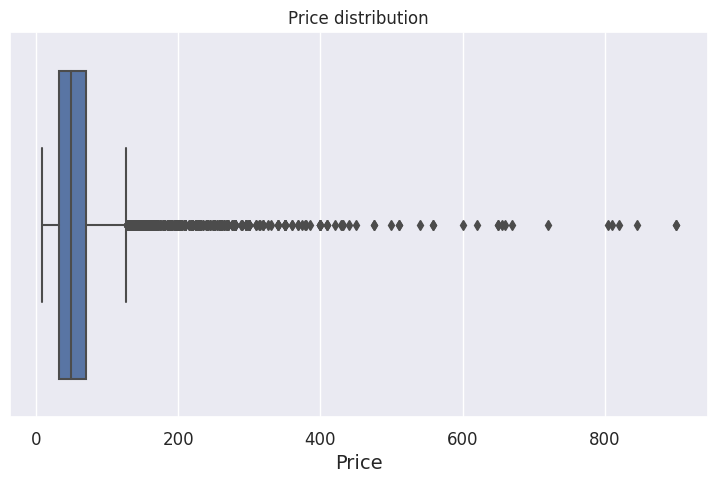

In [5]:
sns.boxplot(x='Price', data=data)
plt.title('Price distribution')

- The figure shows that **75%** of the entries have a price less than **100** and a small percentage of the entries are above **200** (outliers).

- The following segmentation of the variable 'Price' is considered: **[0,25,50,75,100,125,150,200,1000]**

In [6]:
bins = [0,25,50,75,100,125,150,200,1000]
def split_train_test_stratify_regression(data: pd.DataFrame, test_size, random_state = None) -> Tuple(pd.DataFrame, pd.DataFrame):
    """
    Splits the data into train and test set, stratifying on the price range.
    """
    data['Price Range'] = pd.cut(x=data['Price'], bins=bins, labels=["price" + str(i) for i in range(0, len(bins)-1)])
    train, test = train_test_split(data, test_size=test_size, stratify=data['Price Range'], random_state=random_state)
    train.drop(columns=['Price Range'], inplace=True)
    test.drop(columns=['Price Range'], inplace=True)
    return train, test

In [7]:
train, test = split_train_test_stratify_regression(data,test_size, random_state=random_state)

## Data Analysis

### Missing Values

,Missing Ratio %
Listing Name,100.00
Square Feet,98.17
Host Response Rate,46.50
Host Response Time,45.31
Checkin Rating,19.16
Location Rating,19.15
Value Rating,19.15
Communication Rating,19.14
Cleanliness Rating,19.14
Accuracy Rating,19.14


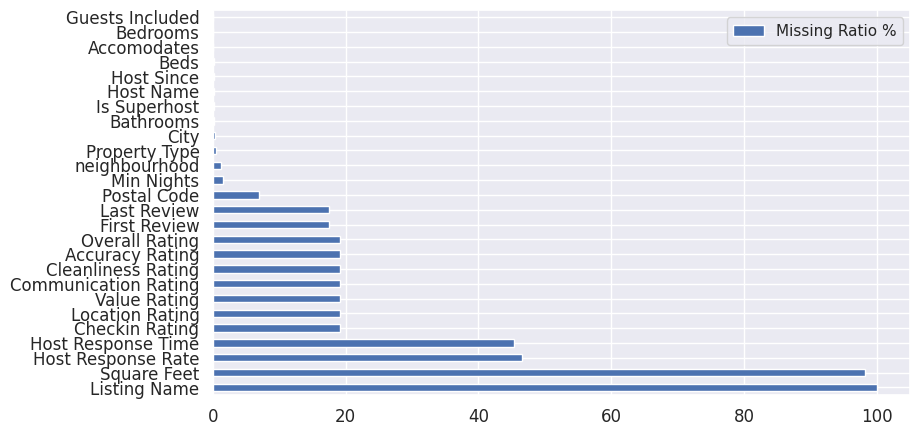

In [8]:
# NaN values analysis
def plot_nans_percentage(df: pd.DataFrame)->None:
    """
    Plots the NaN percentage in each column
    """
    if df.isnull().sum().sum() != 0:
        na_df = (df.isnull().sum() / len(df)) * 100
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        display(missing_data)
        missing_data.plot(kind = "barh")
        plt.show()
    else:
        print('No NaN value found')

plot_nans_percentage(train)

- The columns Listing Name, Square Feet, Host Response Rate and Host Response Time have high missing ratios respectively equal to 100%, 98.2%,46.5% and 45.3%. They will be dropped.

- As the missing ratio for columns related to ratings are similar, the distribution of the NaN over these columns and the relationship between them should be studied.

In [9]:
# NaN distribution for columns related to rating
review_cols = ['Overall Rating', 'Accuracy Rating', 'Cleanliness Rating', 'Checkin Rating', 'Communication Rating', 'Location Rating', 'Value Rating']

review_counts = train[review_cols].isnull().value_counts().to_frame()
review_counts.columns = ['count']
review_counts['proportion'] = review_counts['count'] / review_counts['count'].sum()

print('Distribution of missing data (False = not missing, True = missing)')
review_counts

Distribution of missing data (False = not missing, True = missing)


count  \
Overall Rating Accuracy Rating Cleanliness Rating Checkin Rating Communication Rating Location Rating Value Rating          
False          False           False              False          False                False           False          8875   
True           True            True               True           True                 True            True           2096   
False          True            True               True           True                 True            True              5   
               False           False              True           False                False           False             1   
                                                                                      True            True              1   

                                                                                                                    proportion  
Overall Rating Accuracy Rating Cleanliness Rating Checkin Rating Communication Rating Location Rating Value Rating              
False          False           False              False          False                False           False               0.81  
True           True            True               True           True                 True            True                0.19  
False          True            True               True           True                 True            True                0.00  
               False           False              True           False                False           False               0.00  
                                                                                      True            True                0.00

- Arround 80% of the time, data in the rating columns exist simultaneously and arround 19% of the time, __ALL__ data in the rating columns are missing simultaneously. 

In [10]:
train[review_cols].corr()['Overall Rating']

Overall Rating         1.00
Accuracy Rating        0.60
Cleanliness Rating     0.65
Checkin Rating         0.41
Communication Rating   0.48
Location Rating        0.34
Value Rating           0.61
Name: Overall Rating, dtype: float64

- The column Overall Rating is correlated with the other ratings, we chose to keep only the Overall Rating column and focus on imputing its missing values.

### Categorical Features

- The columns **Country Code**, **Country** and **City** will be dropped as they correspond to Berlin.

In [11]:
# Room Type column
train['Room Type'].value_counts()

Private room       5479
Entire home/apt    5393
Shared room         106
Name: Room Type, dtype: int64

- For Room Type column there is an order between the different categories s.t: **Shared room < Private room < Entire home/ap**. Ordinal Encoding is going to be applied.

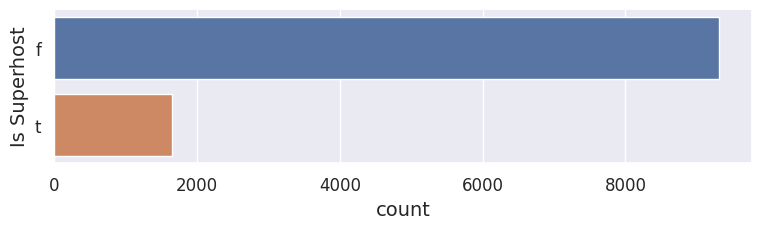

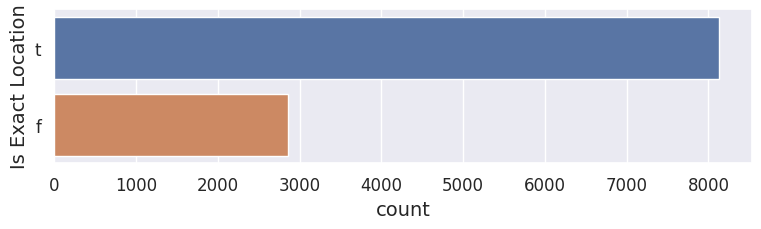

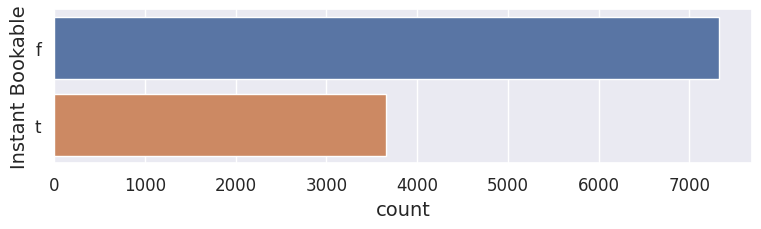

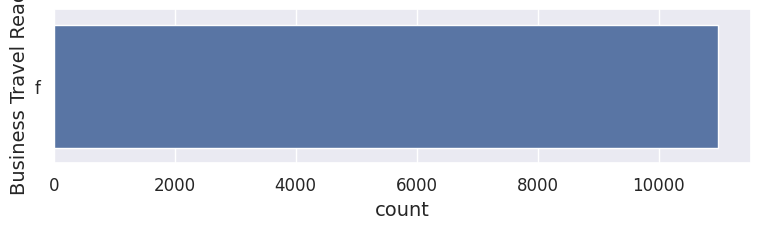

In [12]:
# Display count plot for binary columns
for col in ['Is Superhost', 'Is Exact Location', 'Instant Bookable', 'Business Travel Ready']:
    counts = train[col].value_counts(ascending=False)
    plt.figure(figsize=(9, 2))
    sns.countplot(y=train[col], order=counts.index)
    plt.show()

- Variables taking a single value only, will be dropped. The column **Business Travel Ready** is constant equal to ’f’ and will be dropped.

<AxesSubplot: xlabel='count', ylabel='Property Type'>

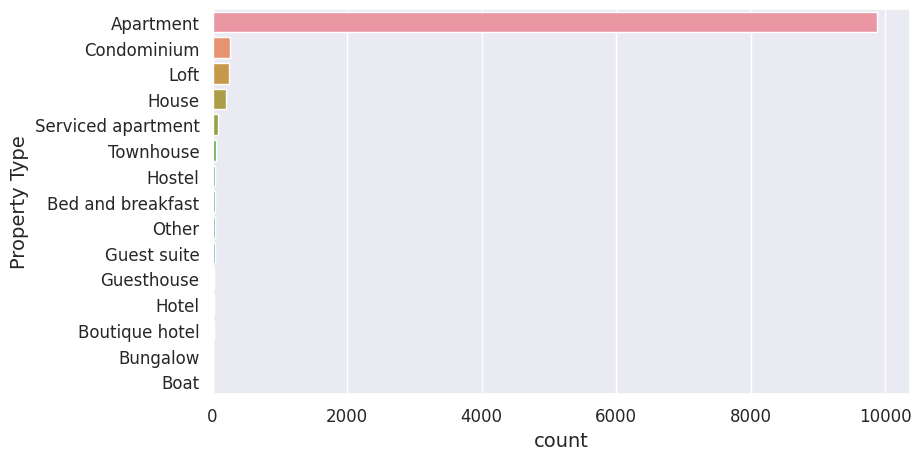

In [13]:
# Property type variable analysis
counts = train['Property Type'].value_counts(ascending=False)
sns.countplot(y=train["Property Type"], order=counts.index)

- For Property Type **90%** of listings are apartments, doing a binary encoding based on whether the listing is an apartment or not could be very selective.
- One-hot encoding will be adopted where infrequent types are grouped (under 1%).

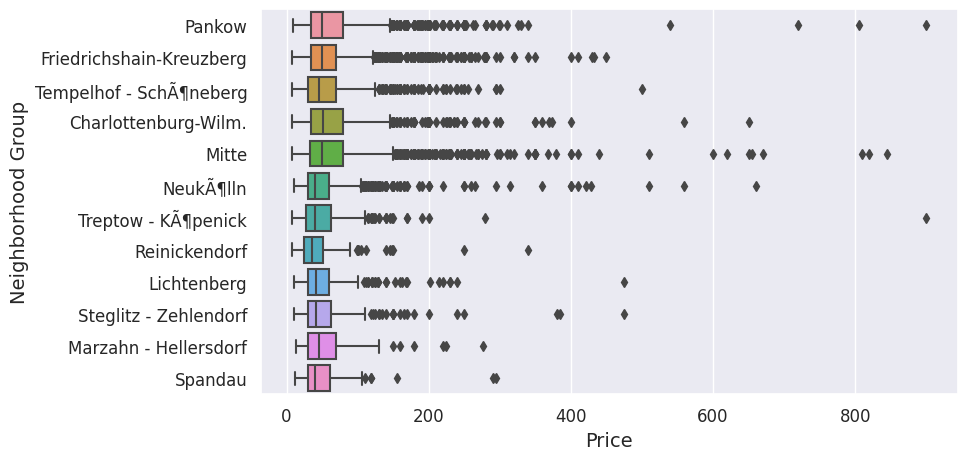

In [14]:
# Neighborhood Group variable analysis
sns.boxplot(x='Price', y='Neighborhood Group', data=data)
plt.show()

<AxesSubplot: xlabel='Longitude', ylabel='Latitude'>

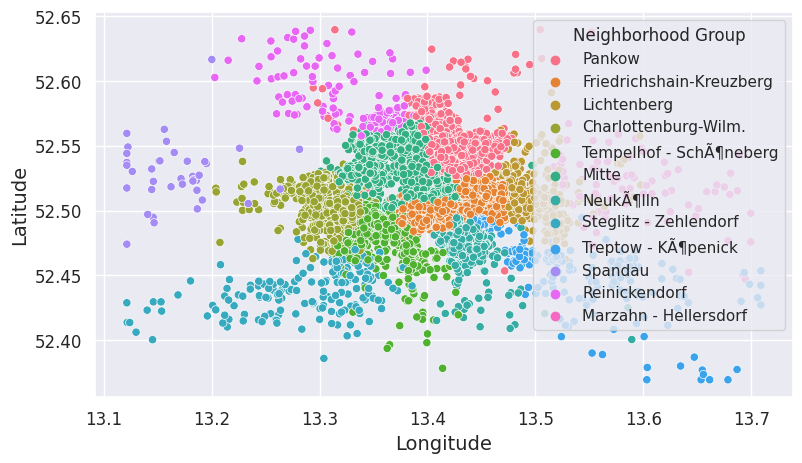

In [15]:
sns.scatterplot(x='Longitude', y='Latitude', hue='Neighborhood Group', data=train)

In [16]:
pd.DataFrame({'mean': train.groupby('Neighborhood Group')['Price'].mean(),
              'std': train.groupby('Neighborhood Group')['Price'].std(),
              'count': train['Neighborhood Group'].value_counts()}).sort_values(['std'])

,mean,std,count
Reinickendorf,44.50,29.83,141
Treptow - KÃ¶penick,49.36,33.23,305
Lichtenberg,51.84,40.24,368
Marzahn - Hellersdorf,57.04,41.96,89
NeukÃ¶lln,50.19,42.28,1758
Friedrichshain-Kreuzberg,60.66,42.64,2646
Tempelhof - SchÃ¶neberg,56.57,44.02,736
Charlottenburg-Wilm.,68.73,52.74,742
Pankow,66.01,54.08,1758
Steglitz - Zehlendorf,56.09,55.55,203


In [17]:
pd.DataFrame({'mean': train.groupby('neighbourhood')['Price'].mean(),
              'std': train.groupby('neighbourhood')['Price'].std(),
              'count': train['neighbourhood'].value_counts()}).sort_values(['std'])

,mean,std,count
Dahlem,55.80,16.69,10
Karow,41.57,17.95,7
Karlshorst,44.87,18.96,30
Reinickendorf,37.66,19.30,76
Friedrichsfelde,45.00,20.19,41
...,...,...,...
Wilhelmstadt,84.36,74.81,11
Tiergarten,91.08,80.05,74
WeiÃensee,60.92,80.24,138
Nikolassee,80.14,115.15,14


In [18]:
# Correlation Test between categorical variables: Neighborhood Group and neighbourhood
def check_categorical_correlation(col1, col2):
    ndf = pd.crosstab(index=train[col1], columns=train[col2])
    chi2, p, dof, expected = chi2_contingency(ndf)
    print(f'Columns : {col1}, {col2}')
    print(f'P-value: {p:.2g}')
    if p < 0.05:
        print('High correlation')
    print()

check_categorical_correlation('Neighborhood Group', 'neighbourhood')

Columns : Neighborhood Group, neighbourhood
P-value: 0
High correlation



- Based on the previous analysis, Neighborhood Group has fewer categories compared to neighbourhood variable where even some categories are under represented.

### Numerical Features

Text(0.5, 1.0, 'Outliers for numeric features (after normalization)')

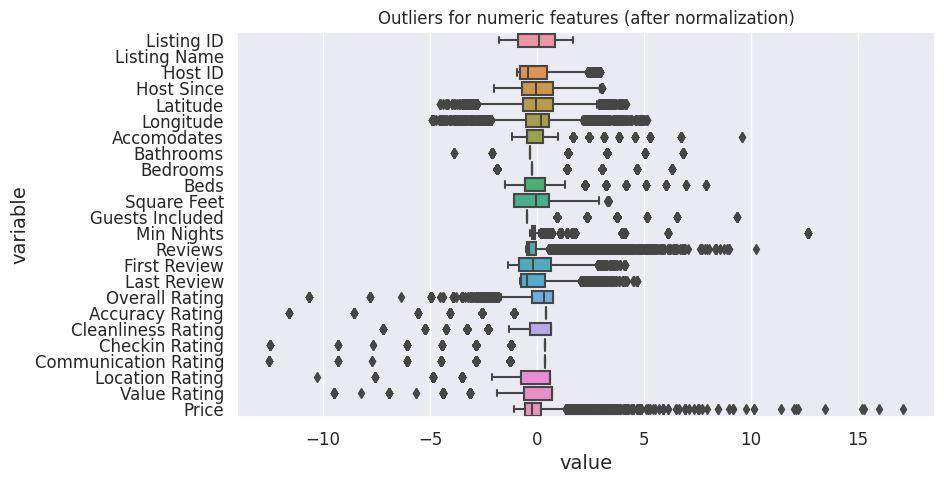

In [19]:
# Outliers analysis
numeric = train.select_dtypes(include=['int', 'float'])
numeric = (numeric - numeric.mean()) / numeric.std()
sns.boxplot(x='value', y='variable', data=numeric.melt(value_vars=numeric.columns))
plt.title('Outliers for numeric features (after normalization)')

- As there are outliers in the data, Robust scaler will be used.

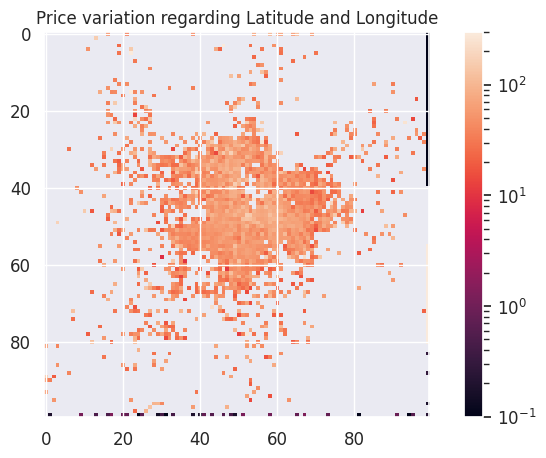

In [20]:
#Price variation regarding Latitude and Longitude 
N = 100
lat, lon = np.meshgrid(np.linspace(train['Latitude'].min(),  train['Latitude'].max(),  N),
                       np.linspace(train['Longitude'].min(), train['Longitude'].max(), N))

mean_price = np.empty_like(lat)
for i in range(mean_price.shape[0]-1):
    for j in range(mean_price.shape[1]-1):
        mask_lat = (lat[i, j] <= train['Latitude']) & (train['Latitude'] < lat[i+1, j+1])
        mask_lon = (lon[i, j] <= train['Longitude']) & (train['Longitude'] < lon[i+1, j+1])
        mean_price[i, j] = np.mean(train['Price'][mask_lat & mask_lon])
plt.title('Price variation regarding Latitude and Longitude')
plt.imshow(mean_price, norm=LogNorm(vmin=0.1, vmax=300))
plt.colorbar()

- The Price tends to increase the closer we are to Berlin center. 
- Using this information and the Longitude and Latitude columns, the **Haversine** library will be used to calculate each AirBnB’s distance from Berlin center and a new column will be added. 

# Preprocessing - Pipeline

In [21]:
# Helpers

## Columns Selector
columns_to_keep = [
    # Keep as-is
    'Host Since', 'Latitude', 'Longitude', 'Accomodates', 'Bathrooms', 'Bedrooms',
    'Beds', 'Guests Included', 'Min Nights', 'Reviews',
    'First Review', 'Last Review', 'Overall Rating',

    # One-hot encoding
    'Neighborhood Group', 'Property Type',

    # Ordinal encoding
    'Room Type',

    # Convert to  bool
    'Is Superhost', 'Instant Bookable', 'Is Exact Location',
]
column_selector = FunctionTransformer(lambda df: df[columns_to_keep])

## Longitude Latitude Transformer
berlin_lat_long = (52.520008, 13.404954)
def transform_lat_lon(df):
    """
        Adds a new column to the dataframe with the distance to Berlin
    """
    latlon = pd.Series(tuple(zip(df.Latitude, df.Longitude)), index=df.index)
    df['to_berlin'] = latlon.apply(lambda row: haversine(berlin_lat_long, row))
    return df


## Column Transformer
column_preprocessor = make_column_transformer(
    (
        OneHotEncoder(drop=None, min_frequency=0.01),
        ['Neighborhood Group', 'Property Type']
    ),
    (
        OrdinalEncoder(categories=[['Shared room', 'Private room', 'Entire home/apt']]),
        ['Room Type']
    ),
    (
        FunctionTransformer(lambda df: (df == 't').astype('int'), feature_names_out='one-to-one'),
        ['Is Superhost', 'Instant Bookable', 'Is Exact Location']
    ),
    (
        FunctionTransformer(transform_lat_lon, feature_names_out=lambda *_: ['Latitude', 'Longitude', 'to_berlin']),
        ['Latitude', 'Longitude']
    ),
    remainder='passthrough',
    verbose_feature_names_out=False,
)

In [22]:
# Pipeline
pipeline_preprocessing = Pipeline(
    [
        ('column selector', column_selector),
        ('column encoder/preprocessor', column_preprocessor),
        ('imputer', IterativeImputer(sample_posterior=True, random_state=42, verbose=1)),
        ('scaler', RobustScaler()),
    ],
    verbose=True,
)

In [23]:
def preprocess(pipeline: Pipeline, train: pd.DataFrame, test: pd.DataFrame):
    def to_df(values):
        return pd.DataFrame(values, columns=pipeline_preprocessing[1].get_feature_names_out())
    train_transformed = pipeline.fit_transform(train)
    test_transformed = pipeline.transform(test)
    return to_df(train_transformed), to_df(test_transformed)

X_train_transformed, X_test_transformed = preprocess(pipeline_preprocessing, train, test)
y_train = train['Price']
y_test = test['Price']

[Pipeline] ... (step 1 of 4) Processing column selector, total=   0.0s
[Pipeline]  (step 2 of 4) Processing column encoder/preprocessor, total=   0.1s
[IterativeImputer] Completing matrix with shape (10978, 34)
[Pipeline] ........... (step 3 of 4) Processing imputer, total=  18.5s
[Pipeline] ............ (step 4 of 4) Processing scaler, total=   0.1s
[IterativeImputer] Completing matrix with shape (4705, 34)


# Prediction model with PCA

In [24]:
models = [
    GradientBoostingRegressor(random_state=random_state),
    RandomForestRegressor(random_state=random_state),
    AdaBoostRegressor(random_state=random_state),
    XGBRegressor(random_state=random_state),
    KNeighborsRegressor(),
    SVR(),
]

In [25]:
def eval_model(name, model, verbose=False, cv=5):
    scores = cross_val_score(model, X_train_transformed, y_train, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1)
    print(f'RMSE of {name} : {-scores.mean():.2f}')

Text(0.5, 1.0, 'Cumulative explained variance ratio')

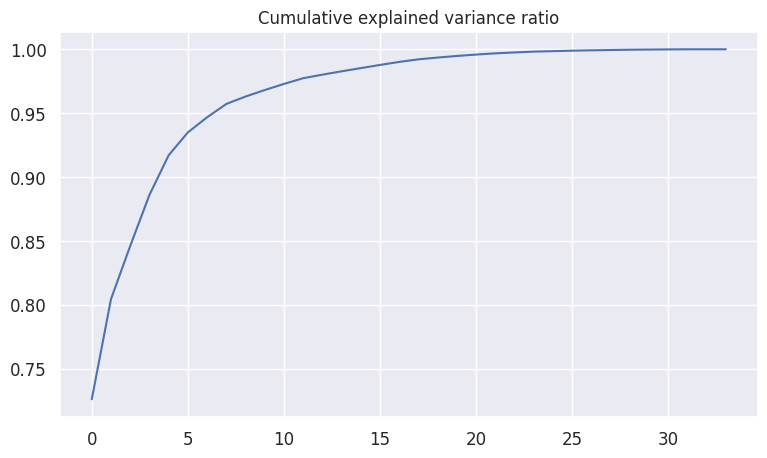

In [26]:
# PCA
pca = PCA(random_state=random_state)
pca.fit(X_train_transformed)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative explained variance ratio')

In [27]:
# PCA with enough components to explain 99% of the variance
pca99 = PCA(0.99)
for model in models:
    eval_model(model.__class__.__name__, make_pipeline(pca99, model))

RMSE of GradientBoostingRegressor : 40.60
RMSE of RandomForestRegressor : 41.20
RMSE of AdaBoostRegressor : 79.59
RMSE of XGBRegressor : 42.04
RMSE of KNeighborsRegressor : 43.00
RMSE of SVR : 42.53


# Prediction Models without PCA

In [28]:
for model in models:
    eval_model(model.__class__.__name__, model)

RMSE of GradientBoostingRegressor : 38.90
RMSE of RandomForestRegressor : 39.95
RMSE of AdaBoostRegressor : 72.37
RMSE of XGBRegressor : 41.27
RMSE of KNeighborsRegressor : 42.30
RMSE of SVR : 42.32


# Model Fine-tuning - Grid Search

- GradientBoosting and RandomForestRegressor are retained for the fine tuning phase.

In [29]:
def grid_search(name, model, params, cv=5):
    """
    Perform grid search for given model and params
    params:
        name: name of the model
        model: model to perform grid search on
        params: params to perform grid search on
        cv: number of folds for cross validation
    """
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_root_mean_squared_error', verbose=3, n_jobs=-1)
    grid_search.fit(X_train_transformed, y_train)
    clear_output()
    display()
    print(f'[{name}]')
    print(f'best RMSE: {-grid_search.best_score_:.2f}')
    print(f'best hyperparams: {grid_search.best_params_}')
    return grid_search

In [31]:
grid_search_gradient_boosting = grid_search('GradientBoostingRegressor', GradientBoostingRegressor(), params={
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.2, 0.1, 0.05],
    'max_depth': [2, 3, 5],
})

[GradientBoostingRegressor]
best RMSE: 38.57
best hyperparams: {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100}


In [ ]:
grid_search_random_forest = grid_search('RandomForestRegressor', RandomForestRegressor(), params={
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2', 1.0],
    'min_samples_split': [2, 5],
})

[RandomForestRegressor]
best RMSE: 38.48
best hyperparams: {'max_depth': None, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 200}


# Final evaluation on the Test set

- The best model is RandomForest on the train/val data

In [30]:
model = RandomForestRegressor(max_depth=20, max_features='log2', min_samples_split=2, n_estimators=200, random_state=random_state)
model.fit(X_train_transformed, y_train)
y_test_pred = model.predict(X_test_transformed)

score = mean_squared_error(y_test, y_test_pred, squared=False)
print(f'RMSE: {score:.2f}')

RMSE: 36.90


- After re-training on the entire training set, the model obtained an RMSE of 36.90 on the testing set

<AxesSubplot: >

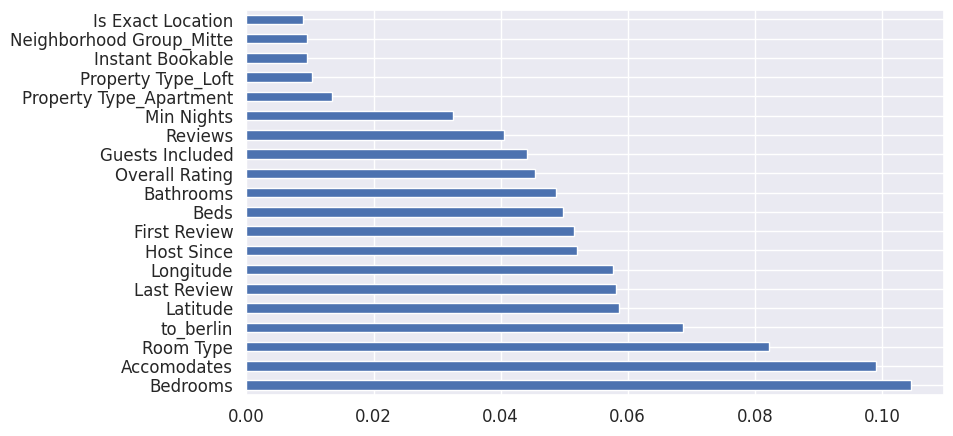

In [31]:
# Feature importance
feature_importance = pd.Series(model.feature_importances_, index=X_train_transformed.columns)
feature_importance.nlargest(20).plot(kind='barh')